In [1]:
using GLMakie
using InteractiveUtils
using Interpolations
using LaTeXStrings
using Logging
using OrdinaryDiffEq
using StaticArrays


# Apagamos los warnings con Julia
Logging.disable_logging(Logging.Info)

LogLevel(1)

In [2]:
# TODO: Programar la función alpha_n como función del voltaje V.
#       Necesitarás definir un caso especial cuando V - 10 < epsilon
#       Utiliza esta celda para ver cómo se comporta tu función en esta vecindad.
#       ¿Qué pasa si epsilon = 0.1? ¿Y si epsilon = 0.01?

# Cargamos las funciones desde un archivo para utilizarlas en múltiples notebooks
include("./code/funciones.jl")

g_k (generic function with 1 method)

# Modelo de Hodgkin-Huxley

\begin{align}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) \\
                   &- g_L (V - E_L) + I_{ext} \\
 \frac{1}{\gamma(T)} \frac{dn}{dt} &= \alpha_n(V) (1 - n) - \beta_n(V)n = \frac{n^{\infty}(V) - n}{\tau_n(V)} \\
 \frac{1}{\gamma(T)} \frac{dm}{dt} &= \alpha_m(V) (1 - m) - \beta_m(V)m = \frac{m^{\infty}(V) - m}{\tau_m(V)} \\
 \frac{1}{\gamma(T)} \frac{dh}{dt} &= \alpha_h(V) (1 - h) - \beta_h(V)h = \frac{h^{\infty}(V) - h}{\tau_h(V)} \\
 \tau_n(V) &= \frac{1}{\alpha_n(V) + \beta_n(V)} \\
 n_{\infty}(V) &= \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)}
\end{align}

Con [Wells]:

* $C_m = 1.0\ \mu\text{F/cm}^2$ la capacitancia de la membrana por unidad de área
* $V$ la diferencia de potencial en la membrana
* $g_{Na} = 120\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el sodio
* $g_{K} = 36\ \text{mS/cm}^2$ la conductancia máxima por unidad de área para el potasio
* $g_{L} = 0.3\ \text{mS/cm}^2$ la conductancia adicional, independiente del voltaje
* $E_{Na} = 55\ \text{mV}$ el voltaje de la batería en la compuerta de sodio
* $E_{K} = -72\ \text{mV}$ el voltaje de la batería en la compuerta de potasio
* $E_{L} = -49.387\ \text{mV}$ el voltaje filtrado
* $\gamma(T)$ es una constante de proporcionalidad temporal que depende de la temperatura $T$, a $6.3°$C vale $1$ [Cessac2009].

para el caso del calamar.  Los potenciales están medidos considerando que la membrana se encuentra en su potencial de reposo a los $V_r = -60\ \text{mV}$.  Las corrientes $I$ están medidas en $\mu A/cm^2$.

Las funciones de transición $\alpha(V)$ y $\beta(V)$, fueron determinadas experimentalmente.  Su forma general es=>
\begin{align}
  \alpha(V) \text{ ó } \beta(V) = \frac{A + BV}{C + H e^{\left(\frac{V+D}{F}\right)}}
\end{align}
donde $V$ está medido con respecto al potencial de reposo $V_r$

Los valores medidos por Hodkin y Huxley para la compuerta de **potasio (K)**, fueron=>
\begin{align}
  \alpha_n(V) &= \frac{0.01(10 - V)}{e^{\left(\frac{10-V}{10}\right)} - 1} & \beta_n(V) &= 0.125 e^{-\frac{V}{80}}
\end{align}
Observemos que cuando $V = 10$ la función está indefinida.  Utilizando la regla de L'Hopital, se calcula el límite:
\begin{align}
  \alpha_n(10) &= \frac{-0.01}{e^{\left(\frac{10-V}{10}\right)}(-0.1)}
               = \frac{-0.01}{-0.1} = 0.1
\end{align}

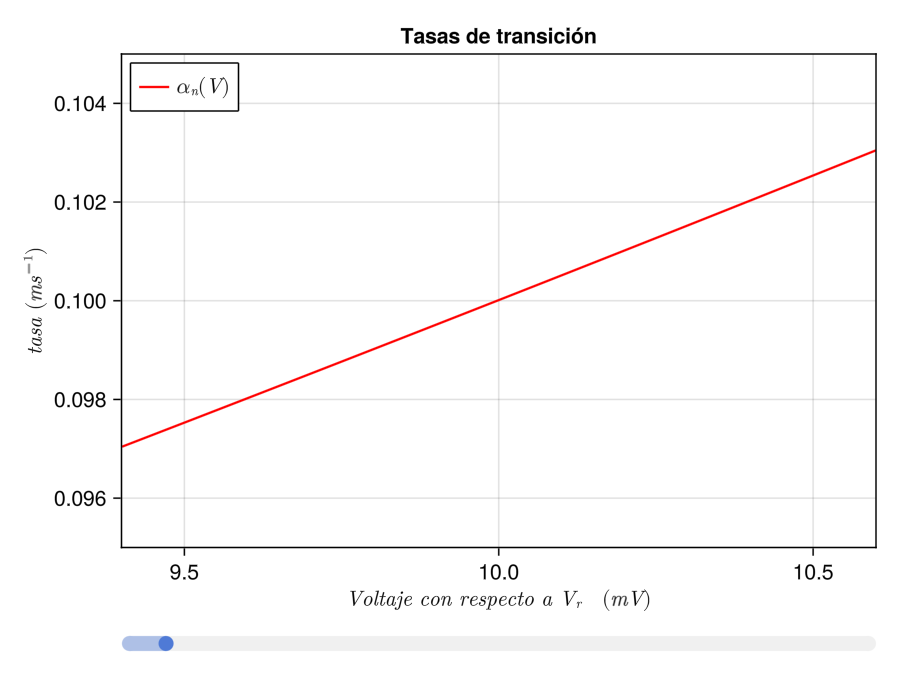

In [8]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    title="Tasas de transición",
    xlabel=L"\textit{Voltaje con respecto a } V_r \quad (mV)",
    ylabel=L"\textit{tasa } (ms^{-1})"
)
step_slider = Slider(fig[2, 1], range=0.0001:0.0001:0.2, startvalue=0.01)

min_x = 9.4
max_x = 10.6
min_y = 0.095
max_y = 0.105

points = lift(step_slider.value) do step
    xs = min_x:step:max_x
    ys = alpha_n.(xs)
    [Point2f(x, y) for (x, y) in zip(xs, ys)]
end

lines!(points, color=:red, label=L"\alpha_n(V)")
limits!(ax, min_x, max_x, min_y, max_y)
axislegend(ax, position=:lt)

fig

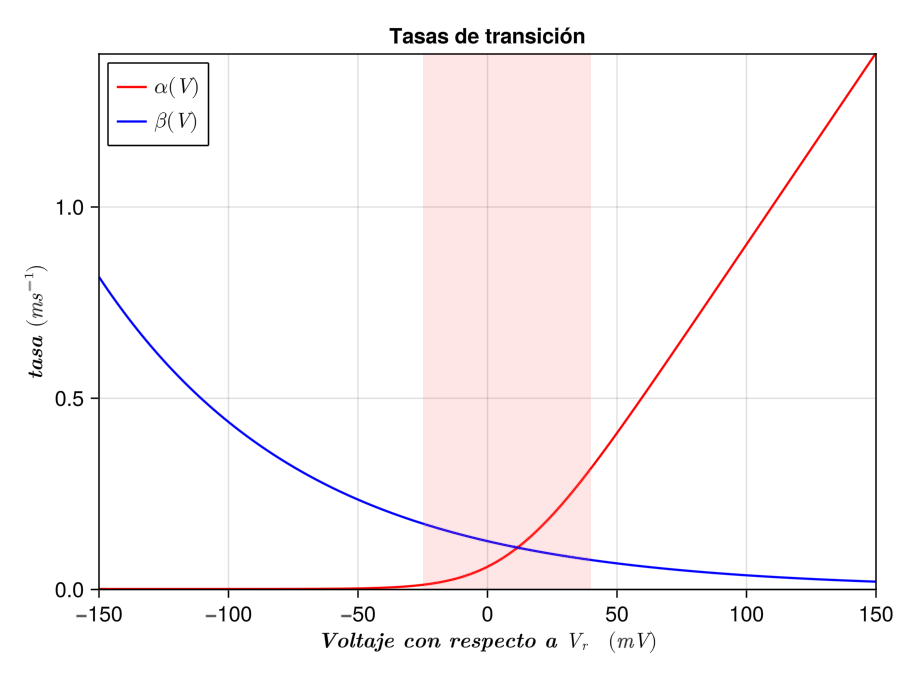

In [9]:
V = -150:0.1:150
alpha = alpha_n.(V)
beta = beta_n.(V)

fig = Figure()
ax = Axis(
    fig[1, 1],
    title="Tasas de transición",
    xlabel=L"\textbf{Voltaje con respecto a } V_r \quad (mV)",
    ylabel=L"\textbf{tasa } (ms^{-1})"
)

lines_red = lines!(V, alpha, color=:red, label=L"\alpha(V)")
lines_blue = lines!(V, beta, color=:blue, label=L"\beta(V)")

axislegend(ax, position=:lt)
limits!(ax, -150, 150, 0, 1.4)
vspan!(ax, -25, 40, color=:red, alpha=0.1, label="")

#=
Legend(
    fig[1, 2],
    [lines_blue, lines_red],
    [L"\alpha(V)", L"\beta(V)"]
)
=#

fig

Las funciones para el **sodio (Na)** son:
\begin{align}
  \alpha_m(V) &= \frac{0.1(25 - V)}{e^{\left(\frac{25-V}{10}\right)} - 1} & \beta_m(V) &= 4 e^{-\frac{V}{18}} \\
  \alpha_h(V) &= 0.07 e^{-\frac{V}{20}} & \beta_h(V) &= \frac{1}{e^{\left(\frac{30-V}{10}\right)} + 1}
\end{align}
Para $\alpha_m$ cuando $V = 25$, utilizamos la regla de L'Hopital para calcular el límite:
\begin{align}
  \alpha_m(25) &= \frac{-0.1}{e^{\left(\frac{25-V}{10}\right)}(-0.1)}
               = \frac{-0.1}{-0.1} = 1
\end{align}

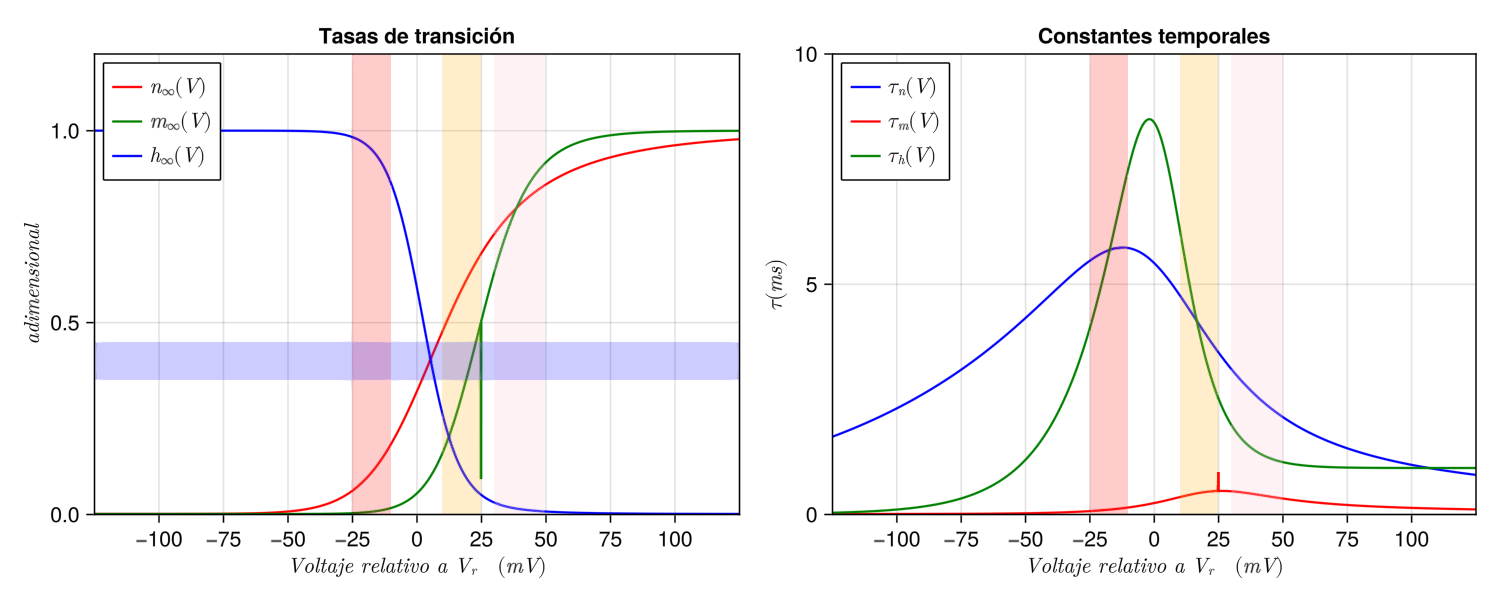

In [11]:
V = -150:0.1:150
alpha = alpha_n.(V)
beta = beta_n.(V)

f = Figure(size=(1000, 400))

axess = [
    Axis(f[1, 1],
        title="Tasas de transición",
        xlabel=L"\textit{Voltaje relativo a } V_r \quad (mV)",
        ylabel=L"adimensional",
        xticks=[-100, -75, -50, -25, 0, 25, 50, 75, 100]
    ),
    Axis(f[1, 2],
        # xscale = Makie.Symlog10(10.0),
        title="Constantes temporales",
        xlabel=L"\textit{Voltaje relativo a } V_r \quad (mV)",
        ylabel=L"\tau (ms)",
        xticks=[-100, -75, -50, -25, 0, 25, 50, 75, 100],
    )
]

alpha = alpha_n.(V)
beta = beta_n.(V)
lines!(axess[1], V, n_inf(alpha, beta), color=:red, label=L"n_{\infty}(V)")
lines!(axess[2], V, tau_inf(alpha, beta), color=:blue, label=L"\tau_{n}(V)")

alpha = alpha_m.(V)
beta = beta_m.(V)
lines!(axess[1], V, n_inf(alpha, beta), color=:green, label=L"m_{\infty}(V)")
lines!(axess[2], V, tau_inf(alpha, beta), color=:red, label=L"\tau_{m}(V)")

alpha = alpha_h.(V)
beta = beta_h.(V)
lines!(axess[1], V, n_inf(alpha, beta), color=:blue, label=L"h_{\infty}(V)")
lines!(axess[2], V, tau_inf(alpha, beta), color=:green, label=L"\tau_{h}(V)")

# Configurando las regiones de la primera gráfica
vspan!(axess[1], [-25, 10, 30], [-10, 25, 50],
    color = [(c, 0.2) for c in [:red, :orange, :pink]])
hspan!(axess[1], 0.35, 0.45, color = (:blue, 0.2))

# Configurando las regiones de la segunda gráfica
vspan!(axess[2], [-25, 10, 30], [-10, 25, 50],
    color = [(c, 0.2) for c in [:red, :orange, :pink]])

limits!(axess[1], -125, 125, 0, 1.2)
limits!(axess[2], -125, 125, 0, 10.0)
axislegend(axess[1], unique=false, merge=true, position=:lt)
axislegend(axess[2], unique=false, merge=true, position=:lt)

f

## Simulación con el método numérico de Euler

El método de Euler realiza una aproxima a la función por su tangente.  Dada una ecuación diferencial de la forma:

\begin{align}
  \frac{dy(t)}{dt} = f(y(t))
\end{align}

Partimos de un punto inicial $(t_0, y_0)$ y a partir de él, se calcula el valor de $y$ para el tiempo $t + \Delta t$ iterativamente como:

\begin{align}
  y(t + \Delta t) &= y(t) + \Delta t f(y(t))
\end{align}

El error aproximado por realizar esta aproximación es:
\begin{align}
  E =& \frac{1}{2} \frac{df(t)}{dt}(\Delta t)^2
\end{align}

Aplicando esta fórmula a la ecuación para los canales:

\begin{align}
 \frac{dn}{dt} &= \frac{n^{\infty}(V) - n}{\tau_n(V)}
\end{align}

Obtenemos:

\begin{align}
 n(t + \Delta t) =& n(t) + \Delta t \left[\frac{n^{\infty}(V)}{\tau_n} - \frac{n(t)}{\tau_n(V)} \right] \\
                 =& \left[ 1 - \frac{\Delta t}{\tau_n(V)} \right] n(t) + \frac{\Delta t}{\tau_n(V)}n^{\infty}(V)
\end{align}

Se obtienen fórmulas análogas para $m$ y $h$.

Se debe realizar el mismo procedimiento con la ecuación diferencial para el voltaje.  Para simplificar la notación, introduzcamos:

\begin{align}
  G_{Na} &= g_{Na}m^3h   &   G_{K} &= g_K n^4
\end{align}

Entonces:
\begin{align}
 C_m \frac{dV}{dt} &= -g_{Na}m^3h(V-E_{Na}) - g_K n^4 (V - E_K) - g_L (V - E_L) + I_{ext} \\
 \frac{dV}{dt} &= -\frac{G_{Na}}{C_m}(V-E_{Na}) - \frac{G_K}{C_m} (V - E_K) - \frac{g_L}{C_m} (V - E_L) + \frac{1}{C_m}I_{ext}
\end{align}

Utilizando el método de Euler:

\begin{align}
 V(t + \Delta t) &= V(t) - \frac{\Delta t \left[ G_{Na}(V-E_{Na}) + G_K (V - E_K) + g_L (V - E_L) + I_{ext}(t) \right]}{C_m}
\end{align}

Para asignar los valores iniciales, asumiremos que el valor $V(0)$ es dado, por lo que los valores iniciales de las $\alpha$, $\beta$ se calculan a partir de él.  Para los valores de $n,m$ y $h$ asumiremos que se llegó al equilibrio y se usarán $n_{\infty},m_{\infty}$ y $h_{\infty}$.


Para los valores por defecto propuestos en la celda siguiente, programar una simulación utilizando el método de Euler produce la figura siguiente:

<img src="./figuras/Simulacion.png">

In [30]:
include("code/euler_hodgkin_huxley.jl")


"""
Crea una función que representa la corriente externa aplicada al 
modelo de Hodgkin-Huxley.
"""
function make_i_ext(t0=10.0, tfin=16.0, current=6.5)
    function i_ext(t)
        if t0 <= t <= tfin
            return current
        end

        return 0.0
    end

    return i_ext
end

"""
Función que nos permite realizar la ejecución del algoritmo dados los
parámetros del modelo de Hodgkin-Huxley.
"""
function euler_hodgkin_huxley(params)

    gNa = params["gNa"]
    gK = params["gK"]
    gL = params["gL"]
    Cm = params["Cm"]
    ENa = params["ENa"]
    EK = params["EK"]
    EL = params["EL"]
    DeltaT = params["DeltaT"]
    maxT = params["maxT"]
    i_ext = params["i_ext"]

    """
    Modelo de Hodgkin-Huxley, describe las ecuaciones diferenciales que 
    rigen el comportamiento de la neurona.
    :param du: Derivada de u
    :param u: Estado actual
    :param p: Parámetros
    :param t: Tiempo
    """
    function hodgkin_huxley!(du, u, p, t)
        V, n, m, h = u
        i_ext = p[1](t)

        du[1] = (i_ext - gNa * m^3 * h * (V - ENa) - gK * n^4 * (V - EK) - gL * (V - EL)) / Cm
        du[2] = alpha_n.(V) * (1 - n) - beta_n.(V) * n
        du[3] = alpha_m.(V) * (1 - m) - beta_m.(V) * m
        du[4] = alpha_h.(V) * (1 - h) - beta_h.(V) * h
    end

    """
    Función que nos permite generar los resultados de la aproximación utilizando
    la libreria OrdinaryDiffEq.
    :param u0: Estado inicial
    :param tspan: Rango de tiempo
    :param p: Parámetros
    """
    function initial_conditions(u0, tspan, p)
        prob = ODEProblem(hodgkin_huxley!, u0, tspan, p)
        sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
        return sol
    end

    # TODO: Implementar el algoritmo de integración numérica de Euler para
    # calcular V(t). Asegurate de que, al ejecutar la simulación con los
    # parémetros por defecto, se reproduce la imagen de arriba.

    # Estado inicial
    n0 = n_inf.(alpha_n.(params["V0"]), beta_n.(params["V0"]))
    m0 = n_inf.(alpha_n.(params["V0"]), beta_n.(params["V0"]))
    h0 = n_inf.(alpha_n.(params["V0"]), beta_n.(params["V0"]))

    u0 = [params["V0"], n0, m0, h0]
    tspan = (0.0, maxT)
    p = [i_ext]

    solutions = initial_conditions(u0, tspan, p)

    res = Dict(
        "t" => solutions.t,
        "V" => solutions[1,:],
        "n" => solutions[2,:],
        "m" => solutions[3,:],
        "h" => solutions[4,:]
    )

    alphas_m = alpha_m.(res["V"])
    alphas_n = alpha_n.(res["V"])
    alphas_h = alpha_h.(res["V"])

    betas_n = beta_n.(res["V"])
    betas_m = beta_m.(res["V"])
    betas_h = beta_h.(res["V"])

    res["gNa"] = g_na.(gNa, res["m"], res["h"])
    res["gK"] = g_k(gK, res["n"])

    res["τ_n"] = tau_inf.(alphas_n, betas_n)
    res["τ_m"] = tau_inf.(alphas_m, betas_m)
    res["τ_h"] = tau_inf.(alphas_h, betas_h)

    return res
end

"""
Función que nos permite graficar la simulación del modelo de Hodgkin-Huxley.
"""
function simula_hodgkin_huxley(params)
    res = euler_hodgkin_huxley(params)
    plot_simulation(res)
end

simula_hodgkin_huxley

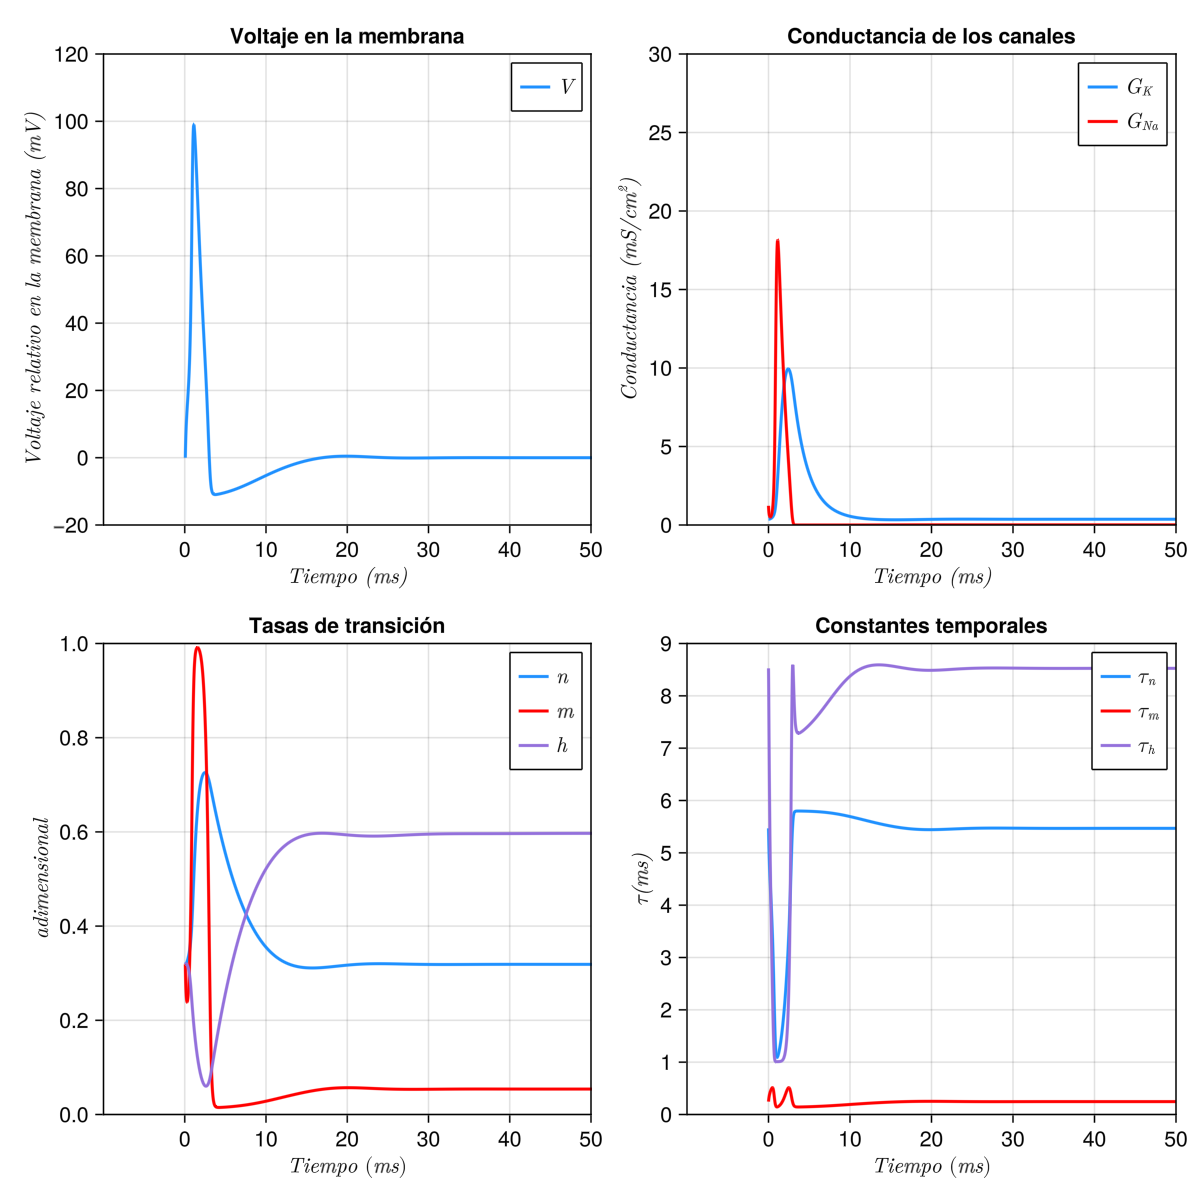

In [33]:
params = Dict(
    "DeltaT" => 0.01, # ms
    "maxT" => 50.0, # ms
    "V0" => 0.0, # mV
    "gNa" => 120.0, # mS/cm2
    "gK" => 36.0,
    "gL" => 0.3,
    "Cm" => 1.0, # micro F/cm2
    "ENa" => 115.0, # Utilizando la convensión original de Hodkin-Huxley
    "EK" => -12.0,
    "EL" => 10.613,
    "i_ext" => make_i_ext(0, 50, 0),
    "t0" => 0
)

simula_hodgkin_huxley(params)